這一章會檢視其他常見的樣式以及如何以Python實作  
我們討論〝傳統〞設計與Python版本  
* 各種模式
* 每一種模式在 Python 中的正規實作
* 取代特定模式的Python語法

# decorator 模式
---
decorator模式讓我們能〝包裝〞提供核心功能的物件與其他改變此功能的物件  
任何使用此裝飾過物件的物件能以他尚未裝飾過的相同方式與其互動  
decorator模式有兩個主要用途：
* 加強元件傳送資料給另一個元件時的回應
* 支援多個選擇性的行為

## decorator範例
建立一個網路範例  
我們會使用 TCP Socket  
`socket.send()`以一個字串作為輸入位元組並將他們輸出到另一端地接收方socket上  
有很多函式庫接受socket並存取此功能以傳送資料到串流上    

以下code需在終端機上執行

```
import socket

def respond(client):
    response = input("Enter a value: ")
    client.send(bytes(response, 'utf8'))
    client.close()

server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server.bind(('localhost',2401))
server.listen(1)
try:
    while True:
        client, addr = server.accept()
        respond(client)
finally:
    server.close()
```
`respond` 函式接受 `socket` 參數並提示要被傳送的資料當作回應然後將他發送  
我們建構一個伺服器 socket 並告訴她傾聽本機上的埠 2401  
當用戶端連上時  
他呼叫 `respond` 以互動的請求資料與做出回應  
注意重點  
`respond` 只在乎 socket 介面上的 `send` 與 `close`  
接下來簡單撰寫一個 client 端來連結

```
import socket

client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
client.connect(('localhost', 2401))
print(f'Recieved: {client.recv(1024)}')
client.close()
```

要使用這些程式時  
1. 在終端機上啟動伺服器
2. 開啟另一個終端機執行用戶端  
3. 在伺服器視窗的 **Enter a value** 輸入值
4. 用戶端會接收輸入並輸出到終端然後結束，執行用戶端第二次，伺服器會提示第二個值
  
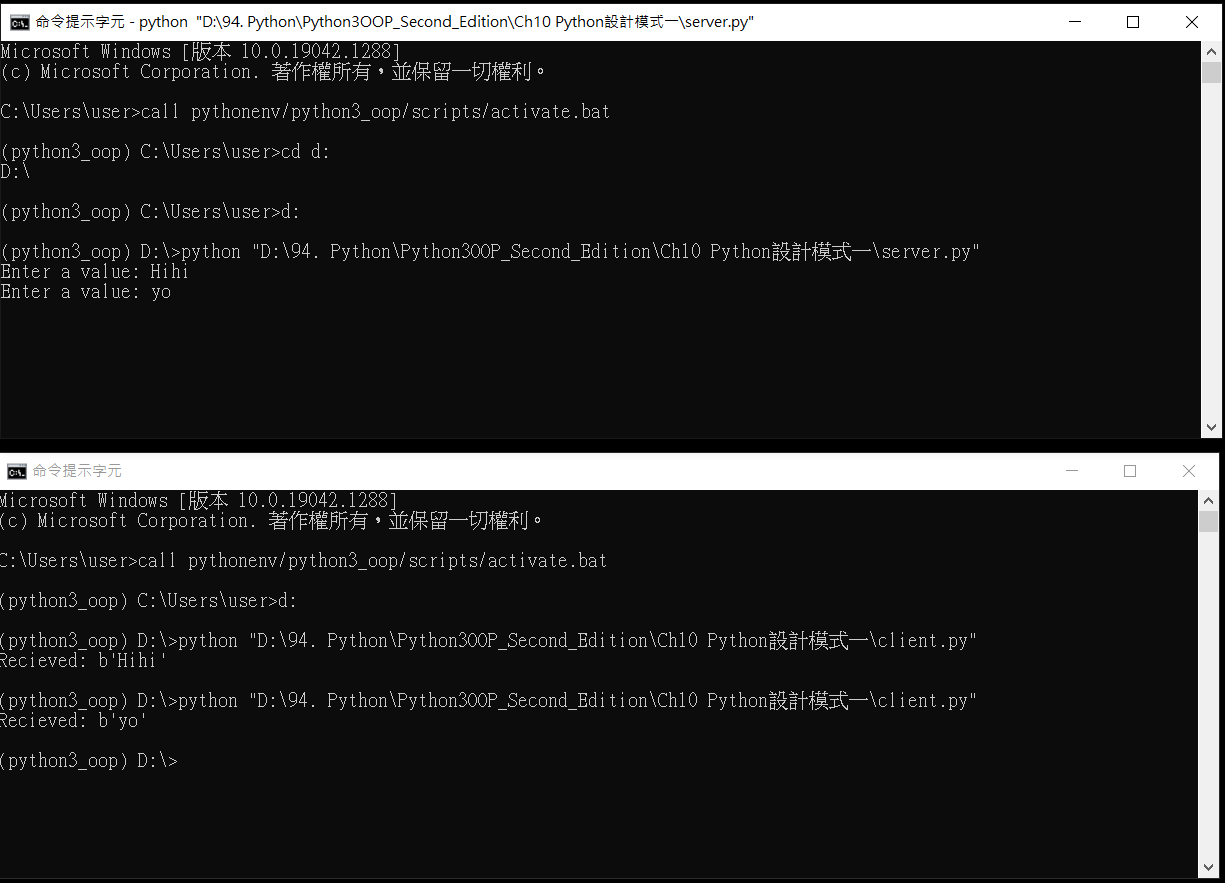

後面暫略...  
尚未讀懂

# Python 中的 decorator
decorator 模式在 Python 中有用  
但還有其他選擇  
例如第七章提到的猴子修補  
在 Python 函式中使用此模式很常見  
也提供了特殊語法讓 decorator 套用在函式上更方便

In [3]:
import time

def log_calls(func):
    def wrapper(*args, **kwargs):
        now = time.time()
        print(f"Calling {func.__name__} with {args} and {kwargs}")
        return_value = func(*args, **kwargs)
        print(f"Excuted {func.__name__} in {time.time()-now}ms\n")
        return return_value
    return wrapper

def test1(a,b,c):
    print("\ttest1 called")

def test2(a,b):
    print("\ttest2 called")

def test3(a,b):
    print("\ttest3 called")
    time.sleep(1)

test1 = log_calls(test1)
test2 = log_calls(test2)
test3 = log_calls(test3)

test1(1,2,3)
test2(4,b=5)
test3(6,7)

Calling test1 with (1, 2, 3) and {}
	test1 called
Excuted test1 in 0.0010123252868652344ms

Calling test2 with (4,) and {'b': 5}
	test2 called
Excuted test2 in 0.0ms

Calling test3 with (6, 7) and {}
	test3 called
Excuted test3 in 1.0061123371124268ms



這個程式由三個任務組成
* 接受另一個函式的 log_calls 函式
* 此函式定義稱為 `wrapper` 的新函式，在呼叫原始函式之前執行一些額外工作
* 回傳新函式
  
相較於在方法定義之後套用decorator函式  
我們可使用 `@decorator` 語法一次完成

In [4]:
@log_calls
def test1(a,b,c):
    print("\ttest1 called")

test1(1,2,3)

Calling test1 with (1, 2, 3) and {}
	test1 called
Excuted test1 in 0.0009970664978027344ms



這種語法好處是可以輕易在定義時看出該函式被裝飾過

# Observer 模式
---
Observer模式對狀態監控與事件處理狀況很有用  
此模式讓一個物件可被未知與動態群組中的〝觀察者〞物件監控  
只要核心物件上的值改變  
他會呼叫 `update()` 方法讓所有 `observer` 物件知道發生了改變  
核心物件改變時每個 observer 可以負責不同的任務  

## Observer 範例
撰寫一個維護特定值的核心物件  
然後讓一個或多個 `observer` 建構該物件的一系列副本  
舉例來說  
這些複製品可能儲存在遠端機器或本機檔案中的資料庫  
讓我們以屬性實作核心物件

In [5]:
class Inventory:
    def __init__(self) -> None:
        self.observers = []
        self._product = None
        self._quantity = 0

    def attach(self, observer):
        self.observers.append(observer)
    
    def _update_observers(self):
        for observer in self.observers:
            observer()

    @property
    def product(self):
        return self._product
    
    @product.setter
    def product(self, value):
        self._product = value
        self._update_observers()
    
    @property
    def quantity(self):
        return self._quantity
    
    @quantity.setter
    def quantity(self, value):
        self._quantity = value
        self._update_observers()

此物件有兩個屬性  
設置時會呼叫本身的 `_update_observers`  
此函式做的是逐個讓每一個有效的 `observer` 知道有些東西改變了  
在這種情況下  
我們直接呼叫 `observer` 物件  
該物件會實作 `__call__` 處理更新  
  
現在實作一個 `observer` 物件  
這個物件會輸出一些狀態到控制台 

In [7]:
class ConsoleObserver:
    def __init__(self, inventory) -> None:
        self.inventory = inventory
    
    def __call__(self):
        print(self.inventory.product)
        print(self.inventory.quantity)

In [8]:
i = Inventory()
c = ConsoleObserver(i)
i.attach(c)
i.product = "Widget"

Widget
0


In [9]:
i.quantity = 5

Widget
5


將 `observe` 附上庫存物件後  
只要改變其中一個受觀察的屬性  
`observer` 就會被呼叫並執行他的動作  

In [11]:
i = Inventory()
c1 = ConsoleObserver(i)
c2 = ConsoleObserver(i)
i.attach(c1)
i.attach(c2)
i.product = 'Gadget'
i.quantity = 1

Gadget
0
Gadget
0
Gadget
1
Gadget
1


上述範例  
兩個 `observer` 同時監看一個庫存物件  
所以當庫存物件更新時  
會有兩組輸出  

Observer 模式將被監控的程式碼與執行監控的程式碼分離  
如果不使用此模式  
我們就要將程式放在每個屬性上處理各種不同的狀況，記錄到控制台、更新資料庫或檔案等等  
每個任務都混入監控物件  
維護起來會很麻煩

# Strategy 模式
---
strategy 模式是物件導向中常見的抽象化示範  
此模式對單一問題實作不同的解決方案  
然後用戶端程式可於執行期間  
動態的選擇最適合的實作
  
通常不同的演算法有不同的取捨  
比較快的可能佔用較多記憶體  
另一個算法可能會在多個 CPU 或分散式系統更適合

## strategy範例
思考桌面桌布管理員  
當圖片顯示在背景時  
他可以用不同的方式調整大小  
舉例來說  
假設圖片小於螢幕，他可以填滿、置中或放大  
還有其他更複雜的策略  
像是依據螢幕長寬比做縮放  
結合不透明、半透明等等操作  
  
我們從最基本的策略開始
strategy 物件取用兩個輸入  
顯示的圖片與螢幕長寬資料組  
他們回傳圖片大小以及根據特定的策略所操縱過的圖片


In [12]:
from PIL import Image

class TiledStrategy:
    def make_background(self, img_file, desktop_size: tuple):
        in_img = Image.open(img_file)
        out_img = Image.new('RGB', desktop_size)
        num_tiles = [
            o // i + 1 for o, i in zip(out_img.size, in_img.size)
        ]
        for x in range(num_tiles[0]):
            for y in range(num_tiles[1]):
                out_img.paste(
                    in_img,
                    (
                        in_img.size[0] * x,
                        in_img.size[1] * y,
                        in_img.size[0] * (x+1),
                        in_img.size[1] * (y+1)
                    )
                )
        return out_img

class CenteredStrategy:
    def make_background(self, img_file, desktop_size: tuple):
        in_img = Image.open(img_file)
        out_img = Image.new('RGB', desktop_size)
        left = (out_img.size[0] - in_img.size[0]) // 2
        top = (out_img.size[1] - in_img.size[1]) // 2
        out_img.paste(
            in_img,
            (
                left,
                top,
                left + in_img.size[0],
                top + in_img.size[1]
            )
        )
        return out_img    

class ScaledStrategy:
    def ake_background(self, img_file, desktop_size: tuple):
        in_img = Image.open(img_file)
        out_img = in_img.resize(desktop_size)
        return out_img

上方有三個策略  
每一個策略可對應一個按鈕    
且都使用 `PIL` 來執行任務  
思考一下沒有 strategy 模式時  
我們需要將所有程式放在一個大方法中並使用 `if` 陳述來選取要用的策略  
每次有新策略  
就會讓程式更醜更難閱讀

# State模式
---
結構上類似 strategy 模式  
但意圖與目的不同  
state 模式的主要目的線狀態轉換系統  
在某個狀態下的物件可藉由某些活動將其驅動至不同狀態
  
為了完成這項作用或切換狀態而提供介面的 context 類別需要一個管理者  
此類別在內部帶有目前狀態的指標  
每個狀態知道他可進入的其他狀態並會根據叫用行動來轉換狀態  

因此我們會有兩種類別 context 和 多個state  
context 維護目前狀態並將動作轉往 state  
state 類別通常是隱藏狀態  

## state 範例
建構一個 XML 解析工具  
Context 會解析自己  
他取用一個字串作為輸入並讓工具進入初始解析狀態  
這種解析狀態會取用字元  
找尋特定的值並找到值時改變不同的狀態  
期目標是要為每個標籤與內容建構節點物件的樹  
為了讓事情可管理  
我們只會處理XML標籤與標籤名稱  
不處理標籤屬性  
他會解析標籤的文字內容  
不會嘗試解析混合內容
以下是我們要解析的〝簡化版XML〞
```
<book>
    <author>Dusty Phillips</author>
    <publisher>Packt Publishing</publisher>
    <title>Python 3 Object Oriented Programming</title>
    <content>
	<chapter>
	    <number>1</number>
	    <title>Object Oriented Design</title>
	</chapter>
	<chapter>
	    <number>2</number>
	    <title>Objects In Python</title>
	</chapter>
    </content>
</book>
```
在我們檢視狀態與解析器之前  
先思考此程式的輸出  
我們知道想要 Node 物件樹  
他必須知道所有解析的標籤名稱  
應該維護一個父節點指標與子節點清單  

In [13]:
class Node:
    def __init__(self, tag_name, parent = None) -> None:
        self.parent = parent
        self.tag_name = tag_name
        self.children = []
        self.text = ""
    
    def __str__(self):
        if self.text:
            return self.tag_name + ": " + self.text
        else:
            return self.tag_name

此類別在初始化時設置的預設屬性值  
提供 `__str__` 方法於完成時幫助我們將樹結構化  
現在思考解析器需要有什麼狀態  
他會從沒有節點被處理過的狀態開始  
需要一個處理開啟標籤與關閉標籤的狀態  
如何得知下一個節點是開啟標籤、關閉標籤、文字節點?  
我們可以在每個狀態中加入一些邏輯來處理  
